# [第5章: 係り受け解析](http://www.cl.ecei.tohoku.ac.jp/nlp100/#ch5)
夏目漱石の小説『吾輩は猫である』の文章（[neko.txt](http://www.cl.ecei.tohoku.ac.jp/nlp100/data/neko.txt)）をCaboChaを使って係り受け解析し，その結果をneko.txt.cabochaというファイルに保存せよ．このファイルを用いて，以下の問に対応するプログラムを実装せよ．

In [1]:
!ls ../Corpus/neko.txt

../Corpus/neko.txt


In [2]:
! cabocha -f1 -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd ../Corpus/neko.txt > Output/neko.txt.cabocha

## 40. 係り受け解析結果の読み込み（形態素）
形態素を表すクラス`Morph`を実装せよ．このクラスは表層形（`surface`），基本形（`base`），品詞（`pos`），品詞細分類1（`pos1`）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文を`Morph`オブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [3]:
class Morph(object):
    def __init__(self,
                 surface: str,
                 base: str,
                 pos: str,
                 pos1: str):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
        
    def __str__(self):
        args = (self.surface, self.base, self.pos, self.pos1)
        return "surface:%s, base:%s, pos:%s, pos1:%s" % args

In [4]:
sentences_40 = []
with open("Output/neko.txt.cabocha") as neko_cabocha:
    sentence = []
    for line in neko_cabocha:
        if line == "\n" or line == "　	記号,空白,*,*,*,*,　,　,　\n":
            continue
        elif line == "EOS\n":
            sentences_40.append(sentence)
            sentence = []
        elif line[0] == "*":
            # * 文節番号 係り先文節番号(係り先無し=-1) 主辞の形態素番号/機能語の形態素番号 スコア
            pass
        else:
            # 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用型,活用形,原形,読み,発音
            foo = line.split("\t")
            bar = foo[1].split(",")
            surface = foo[0]
            base = "*" if "*\n" == bar[6] else bar[6]
            pos = bar[0]
            pos1 = bar[1]
            sentence.append(Morph(surface, base, pos, pos1))

In [5]:
for morph in sentences_40[2]:
    print(morph)

surface:吾輩は猫である, base:吾輩は猫である, pos:名詞, pos1:固有名詞
surface:。, base:。, pos:記号, pos1:句点


## 41. 係り受け解析結果の読み込み（文節・係り受け）
40に加えて，文節を表すクラス`Chunk`を実装せよ．このクラスは形態素（`Morph`オブジェクト）のリスト（`morphs`），係り先文節インデックス番号（`dst`），係り元文節インデックス番号のリスト（`srcs`）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文を`Chunk`オブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [6]:
class Chunk(object):
    def __init__(self,
                 morphs: list,
                 dst: int,
                 srcs: list):
        self.morphs = morphs
        self.dst = dst
        self.srcs = srcs
        
    def __str__(self):
        morphs_str = ""
        for morph in self.morphs:
            morphs_str += morph.surface
        args = (morphs_str, self.dst, self.srcs)
        return "morphs:%s, dst:%d, srcs:%s" % args

In [7]:
sentences = []
with open("Output/neko.txt.cabocha") as neko_cabocha:
    sentence = []
    chunk = None
    chunk_idx_2_srcs = {}
    for line in neko_cabocha:
        if line == "\n" or line == "　	記号,空白,*,*,*,*,　,　,　\n":
            continue
        elif line == "EOS\n":
            if chunk is not None:
                sentence.append(chunk)
            sentences.append(sentence)
            sentence = []
            chunk = None
            chunk_idx_2_srcs = {}
        elif line[0] == "*":
            if chunk is not None:
                sentence.append(chunk)
            # * 文節番号 係り先文節番号(係り先無し=-1) 主辞の形態素番号/機能語の形態素番号 スコア
            foo = line.split(" ")
            chunk_idx = int(foo[1])
            dst = int(foo[2][:-1])
            if dst in chunk_idx_2_srcs:
                chunk_idx_2_srcs[dst].append(chunk_idx)
            else:
                chunk_idx_2_srcs[dst] = [chunk_idx]
            srcs = [] if chunk_idx not in chunk_idx_2_srcs.keys() else chunk_idx_2_srcs[chunk_idx]
            chunk = Chunk([], dst, srcs)
        else:
            # 表層形\t品詞,品詞細分類1,品詞細分類2,品詞細分類3,活用型,活用形,原形,読み,発音
            foo = line.split("\t")
            bar = foo[1].split(",")
            surface = foo[0]
            base = "*" if "*\n" == bar[6] else bar[6]
            pos = bar[0]
            pos1 = bar[1]
            chunk.morphs.append(Morph(surface, base, pos, pos1))

In [8]:
for chunk in sentences[7]:
    print(chunk)

morphs:吾輩は, dst:5, srcs:[]
morphs:ここで, dst:2, srcs:[]
morphs:始めて, dst:3, srcs:[1]
morphs:人間という, dst:4, srcs:[2]
morphs:ものを, dst:5, srcs:[3]
morphs:見た。, dst:-1, srcs:[0, 4]


## 42. 係り元と係り先の文節の表示
係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [9]:
for sentence in sentences:
    for chunk in sentence:
        if chunk.dst == -1:
            continue

        foo, bar = "", ""

        for morph in chunk.morphs:
            foo += morph.surface
        foo = foo.replace("。", "").replace("、", "")

        for morph_dst in sentence[chunk.dst].morphs:
            bar += morph_dst.surface
        bar = bar.replace("。", "").replace("、", "")

        print("%s\t%s" % (foo, bar))

名前は	無い
まだ	無い
どこで	生れた
生れた	かとんと
かとんと	つかぬ
見当が	つかぬ
何でも	薄暗い
薄暗い	泣いて
じめじめ	泣いて
した所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
始めて	人間という
人間という	ものを
ものを	見た
しかも	そうだ
あとで	聞くと
聞くと	そうだ
それは	そうだ
書生という	人間中で
人間中で	種族であった
一番	獰悪な
獰悪な	種族であった
種族であった	そうだ
この	書生というのは
書生というのは	話である
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
食うという	話である
しかし	思わなかった
その	当時は
当時は	なかったから
何という	考も
考も	なかったから
なかったから	思わなかった
別段	恐し
恐し	思わなかった
いとも	思わなかった
ただ	載せられて
彼の	掌に
掌に	載せられて
載せられて	持ち上げられた
スーと	持ち上げられた
持ち上げられた	時
時	フワフワした
何だか	フワフワした
フワフワした	感じが
感じが	あったばかりである
掌の	上で
上で	落ちついて
少し	落ちついて
落ちついて	見たのが
書生の	顔を
顔を	見たのが
見たのが	人間という
いわゆる	人間という
人間という	ものの
ものの	見始であろう
この	時
時	ものだと
妙な	ものだと
ものだと	思った
思った	感じが
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
装飾されべきはずの	顔が
顔が	つるつるして
つるつるして	薬缶だ
まるで	薬缶だ
その後	逢ったが
猫にも	逢ったが
だいぶ	逢ったが
逢ったが	ない
こんな	片輪には
片輪には	ない
一度も	出会わし
出会わし	ない
た事が	ない
のみならず	突起している
顔の	真中が
真中が	突起している
あまりに	突起している
そうして	吹く
その穴の	中から
中から	吹く
時々	吹く
ぷうぷうと	吹く
煙を	吹く
どうも	咽せぽくて
咽せぽくて	弱った
実に	弱った
これが	ものである
人間の	飲む
飲む	煙草という
煙草という	ものである
ものである	事は
事は	知った
ようやく	知った
この	頃
頃	知った
	おったが
この	書生の
書生の	掌の
掌の	

直らないわねえ」と	顧みる
お盆を	持って
持って	控えた
控えた	御三を
御三を	顧みる
「それは	ところでございます
本当の	ところでございます
もう少し	召し上って
召し上って	ならないと
ご覧に	ならないと
ならないと	わかりますまい」と
とても	善い
善い	薬か
薬か	薬か
悪い	薬か
薬か	わかりますまい」と
わかりますまい」と	持つ
御三は	持つ
一も	二も
二も	なく
なく	持つ
細君の	肩を
肩を	持つ
「何でも	いい
いい	飲まんのだから
飲まんのだから	飲まんのだ
飲まんのだ	ものか
女なんかに	わかる
何が	わかる
わかる	ものか
ものか	黙っていろ」
黙っていろ」	女ですわ」と
「どうせ	女ですわ」と
女ですわ」と	突き付けて
細君が	突き付けて
タカジヤスターゼを	突き付けて
主人の	前へ
前へ	突き付けて
突き付けて	切らせようとする
是非	切らせようとする
詰腹を	切らせようとする
主人は	這入る
何にも	云わず
云わず	這入る
立って	這入る
書斎へ	這入る
細君と	御三は
御三は	笑う
顔を	見合せて
見合せて	笑う
にやにやと	笑う
こんな	ときに
ときに	付いて行って
後	からくっ
からくっ	付いて行って
付いて行って	乗ると
膝の	上へ
上へ	乗ると
乗ると	逢わされるから
大変な	目に
目に	逢わされるから
逢わされるから	見ると
そっと	廻って
庭から	廻って
廻って	上って
書斎の	椽側へ
椽側へ	上って
上って	見ると
障子の	隙から
隙から	覗いて
覗いて	見ると
見ると	おった
主人は	おった
エピクテタスとか	云う
云う	人の
人の	本を
本を	披いて
披いて	おった
見て	おった
もし	わかるなら
それが	わかるなら
平常の	通り
通り	わかるなら
わかるなら	ある
ちょっと	えらい
えらい	ところが
ところが	ある
五六分	すると
すると	叩き付けるように
その	本を
本を	叩き付けるように
叩き付けるように	抛り出す
机の	上へ
上へ	抛り出す
大方	事だろうと
そんな	事だろうと
事だろうと	思いながら
思いながら	注意していると
なお	注意していると
注意していると	書きつけた
今度は	書きつけた
日記帳を	出して下のような
出して下のような	事を
事を	書きつけた
寒月と	神田辺を
根津	上野
上野

があがあ	やる
細君の	話しでは
話しでは	なかったそうだが
ここへ	引越す
引越す	前までは
前までは	なかったそうだが
こんな	癖は
癖は	なかったそうだが
なかったそうだが	ないと
ある時	やり
ふと	やり
やり	やめた
出してから	今日まで
今日まで	やめた
一日も	やめた
やめた	事が
事が	ないと
ないと	いう
ちょっと	厄介な
厄介な	癖であるが
癖であるが	つかん
なぜ	続けているのか
こんな	事を
事を	続けているのか
根気	よく
よく	続けているのか
続けているのか	つかん
吾等猫などには	つかん
到底	つかん
想像も	つかん
それも	聞く
まず	善いとして
善いとして	聞く
「薄ぎたない	猫」とは
猫」とは	ものだと
随分	やる
酷評を	やる
やる	ものだと
ものだと	聞く
なお	聞く
耳を	聞く
立てて	聞く
あとを	聞く
「あんな	声を
声を	出して
出して	なるか
何の	呪いに
呪いに	なるか
なるか	知らん
御維新前は	もので
中間でも	もので
草履取りでも	もので
相応の	作法は
作法は	もので
心得た	もので
もので	おらなかったよ」
屋敷町などで	する
あんな	顔の
顔の	洗い方を
洗い方を	する
する	ものは
ものは	おらなかったよ」
一人も	おらなかったよ」
おらなかったよ」	「そうでございましょうともねえ」
下女は	使用する
無暗に	感服しては
感服しては	使用する
無暗にねえを	使用する
「あんな	主人を
主人を	持っている
持っている	猫だから
猫だから	おやり」
どうせ	来たら
野良猫さ	来たら
今度	来たら
来たら	おやり」
少し	叩いて
叩いて	おやり」
おやり」	とってやります」
「叩いてやりますとも	とってやります」
三毛の	病気に
病気に	なったのも
なったのも	とってやります」
全く	相違ございません
あいつの	御蔭に
御蔭に	相違ございません
相違ございません	もの
もの	とってやります」
きっと	とってやります」
讐を	とってやります」
	飛んだ
飛んだ	冤罪を
冤罪を	蒙った
蒙った	ものだ
こいつは	寄れないと
滅多に	近か
近か	寄れないと
寄れないと	帰った
三毛子には	帰った
とうとう	逢わずに
逢わずに	帰った
	帰って
帰って	見ると
見ると	執っている
主人は	執っている
書斎の	中で


とって	くべたそうです
火に	くべたそうです
王様は	云うそうです
まだ	あったと
未練が	あったと
あったと	見えて
見えて	売ると
余った	三冊を
三冊を	売ると
いくらで	売ると
売ると	聞くと
聞くと	云うそうです
やはり	くれと
九冊分の	ねだんを
ねだんを	くれと
くれと	云うそうです
九冊が	なり
六冊に	なり
なり	なっても
六冊が	なっても
三冊に	なっても
なっても	くべるかも知れないので
代価は	くべるかも知れないので
元の	通り
通り	引かない
一厘も	引かない
引かない	引かせようとすると
それを	引かせようとすると
引かせようとすると	くべるかも知れないので
残ってる	三冊も
三冊も	くべるかも知れないので
火に	くべるかも知れないので
くべるかも知れないので	分りませんね」と
王様は	買ったんですって……
とうとう	高い
高い	御金を
御金を	出して
出して	焚け
焚け	買ったんですって……
余りの	三冊を
三冊を	買ったんですって……
買ったんですって……	分りませんね」と
どうだ	話しで
この	話しで
話しで	分りませんね」と
少しは	分ったろう
書物の	ありがた味が
ありがた味が	分ったろう
分ったろう	分りませんね」と
どうだと	ありがたいんだか
力味むのですけれど	ありがたいんだか
私にゃ	ありがたいんだか
何が	ありがたいんだか
ありがたいんだか	分りませんね」と
まあ	分りませんね」と
分りませんね」と	す
細君は	す
一家の	見識を
見識を	立てて
立てて	す
迷亭の	返答を
返答を	す
促が	す
さすがの	迷亭も
迷亭も	窮したと
少々	窮したと
窮したと	見えて
見えて	じゃらしていたが
袂から	出して
ハンケチを	出して
出して	じゃらしていたが
吾輩を	じゃらしていたが
じゃらしていたが	出す
「しかし	奥さん」と
奥さん」と	考えついたように
急に	考えついたように
何か	考えついたように
考えついたように	出す
大きな	声を
声を	出す
「あんなに	買って
本を	買って
買って	詰め込む
矢鱈に	詰め込む
詰め込む	ものだから
ものだから	云われるんですよ
人から	云われるんですよ
少しは	云われるんですよ
学者だとか	云われるんですよ
何とか	云われるんですよ
この間	ある
ある	文学雑誌を
文学雑誌を	見

「……	あるんだそうでございます」と
水島寒月さんの	事で
事で	あるんだそうでございます」と
御用が	あるんだそうでございます」と
あるんだそうでございます」と	直そうとする
小間使は	直そうとする
気を	利かして
利かして	直そうとする
機嫌を	直そうとする
「寒月でも	知らないんだよ——
水月でも	知らないんだよ——
知らないんだよ——	して」
大嫌いだわ	して」
糸瓜が	したような
戸迷いを	したような
したような	顔を
顔を	して」
して」	頂戴する
第三の	剣突は
剣突は	頂戴する
憐れなる	寒月君が
寒月君が	頂戴する
留守中に	頂戴する
「おや御前いつ	束髪に
束髪に	結ったの」小間使は
結ったの」小間使は	する
ほっと	一息ついて
一息ついて	する
「今日」と	する
なるべく	単簡な
単簡な	挨拶を
挨拶を	する
「生意気だねえ	癖に」と
小間使の	癖に」と
癖に」と	食わす
第四の	剣突を
剣突を	食わす
別方面から	食わす
「そう	して
して	掛けたじゃないか」
新しい	半襟を
半襟を	掛けたじゃないか」
掛けたじゃないか」	しまっておきましたが
「へえ	いただきましたので
せんだって	いただきましたので
御嬢様から	いただきましたので
いただきましたので	勿体ないと
結構	過ぎて
過ぎて	勿体ないと
勿体ないと	思って
思って	しまっておきましたが
行李の	中へ
中へ	しまっておきましたが
しまっておきましたが	易えました」
今までのが	汚れましたから
あまり	汚れましたから
汚れましたから	かけ
かけ	易えました」
易えました」	あるの」
「いつ	ものを
そんな	ものを
ものを	上げた
上げた	事が
事が	あるの」
あるの」	染め出したのでございます
「この	御正月
御正月	御求め遊ばしたので——
白木屋へ	いらっしゃいまして
いらっしゃいまして	御求め遊ばしたので——
御求め遊ばしたので——	染め出したのでございます
鶯茶へ	染め出したのでございます
相撲の	番附を
番附を	染め出したのでございます
妾しには	いやだから
地味過ぎて	いやだから
いやだから	上げようと
御前に	上げようと
上げようと	おっしゃった
おっしゃった	あれでございます」
あれでございます」	いやだ
「あら	いやだ
善く	似合うのね
にくらしいわ」	「恐れ入ります

聞いて来てくれないかって	頼まれた
頼まれた	ものだからね
僕も	ないが
今まで	した
こんな	世話は
世話は	した
した	事は
事は	ないが
ないが	やって来たのさ」
もし	嫌やでないなら
当人同士が	嫌やでないなら
嫌やでないなら	纏めるのも
中へ	立って
立って	纏めるのも
纏めるのも	やって来たのさ」
決して	ないからね——
悪い	事は
事は	ないからね——
ないからね——	やって来たのさ」
それで	やって来たのさ」
「御苦労様」と	答えたが
主人は	答えたが
冷淡に	答えたが
答えたが	分らんが
腹の	内では
内では	分らんが
当人同士と	云う
云う	語を
語を	聞いて
聞いて	分らんが
どう	云う
云う	訳か
訳か	分らんが
分らんが	動かしたのである
ちょっと	動かしたのである
心を	動かしたのである
蒸し	熱い
熱い	夏の夜に
夏の夜に	潜ったような
一縷の	冷風が
冷風が	潜ったような
袖口を	潜ったような
潜ったような	気分に
気分に	なる
元来	男であるが
この	主人は
主人は	男であるが
ぶっ切ら	棒の
棒の	頑固光沢消しを
頑固光沢消しを	製造された
旨として	製造された
製造された	男であるが
男であるが	異にしている
さればと	云って
云って	異にしている
冷酷	不人情な
不人情な	文明の
文明の	産物とは
産物とは	自から
自から	異にしている
その	撰を
撰を	異にしている
彼が	云うと
何ぞと	云うと
云うと	会得できる
むかっ腹を	たてて
たてて	するのでも
ぷんぷん	するのでも
するのでも	会得できる
這裏の	消息は
消息は	会得できる
先日	したのは
鼻と	したのは
喧嘩を	したのは
したのは	話しである
鼻が	食わぬからで
気に	食わぬからで
食わぬからで	話しである
鼻の	娘には
娘には	話しである
何の	罪も
罪も	ない
ない	話しである
実業家は	嫌いだから
嫌いだから	相違ないが
実業家の	金田某も
片割れなる	金田某も
金田某も	相違ないが
嫌に	相違ないが
相違ないが	云わねばならぬ
これも	云わねばならぬ
娘	人とは
その	人とは
人とは	云わねばならぬ
没交渉の	沙汰と
沙汰と	云わねばならぬ
娘には	なくて
恩も	恨みも
恨みも	なくて
なくて	門下生である
寒月は	門下生である
自分が	愛している
実の

河野の	叔母さんの
叔母さんの	形身に
形身に	もらったんで
もらったんで	違います」
同じ	糸織でも
糸織でも	違います」
今の	糸織とは
糸織とは	違います」
たちが	違います」
「そんな	講釈は
講釈は	いい
聞かんでも	いい
値段は	いくらだ」
「十五円の	羽織を
羽織を	着るなんて
着るなんて	身分不相当だ」
「いいじゃありませんか	買っていただき
あなたに	買っていただき
買っていただき	ゃあしまいし」
「その	次は
次は	何だ」
「黒足袋が	一足」
「あなたんで	さあね
代価が	二十七銭」
「山の芋が	一箱」
「山の芋まで	持って
持って	行ったのか
煮て	食うつもりか
食うつもりか	とろろ汁にする
とろろ汁にする	つもりか」
「どう	する
する	つもりか
つもりか	知りません
泥棒の	ところへ
ところへ	行って
行って	聞いていらっしゃい」
「山の芋の	ねだんまでは
ねだんまでは	知りません」
「そんなら	しておこう」
十二円五十銭くらいに	しておこう」
「馬鹿馬鹿しいじゃありませんか	たまるもんですか」
いくら	掘って来たって
唐津から	掘って来たって
掘って来たって	たまるもんですか」
山の芋が	十二円五十銭して
十二円五十銭して	たまるもんですか」
「しかし	ないか」
御前は	知らんと
知らんと	云うじゃ
云うじゃ	ないか」
「知りませんわ	知りませんが
知りませんが	法外です
十二円五十銭なんて	法外です
法外です	もの」
「知らんけれども	何だ
十二円五十銭は	何だ
法外だとは	何だ
まるで	合わん
論理に	合わん
それだから	云うんだ」
貴様は	オタンチン・パレオロガスだと
オタンチン・パレオロガスだと	云うんだ」
「何で	すって」
「何で	云うのは」
すその	オタンチン・パレオロガスって
オタンチン・パレオロガスって	云うのは」
「何でも	いい
それから	出て来んじゃないか」
あとは——	出て来んじゃないか」
俺の	着物は
着物は	出て来んじゃないか」
一向	出て来んじゃないか」
「あとは	うござんす
何でも	うござんす
宜	うござんす
オタンチン・パレオロガスの	意味を
意味を	聞かして
聞かして	頂戴」
「意味も	ある
何にも	ある
ある	もんか」
「教えて	下すっても
下すっても	馬鹿にしていらっしゃるのね
いいじゃありませんか	

よかろう」と	迷亭が
迷亭が	出す
口を	出す
「それで	差し支えない
まず	差し支えない
実験上	差し支えない
差し支えない	球を
くらいな	球を
球を	作って
作って	見ようと
見ようと	思いましてね
せんだってから	やり始めたのです」
やり始めたのです」	「出来たかい」と
「出来たかい」と	きく
主人が	きく
訳の	ないように
ないように	きく
「出来る	ものですか」と
ものですか」と	云ったが
寒月君が	云ったが
云ったが	むずかしいです
これでは	気が付いたと
少々	矛盾だと
矛盾だと	気が付いたと
気が付いたと	見えて
見えて	むずかしいです
「どうも	むずかしいです
だんだん	磨って
磨って	長過ぎるからと
少し	長過ぎるからと
こっち側の	半径が
半径が	長過ぎるからと
長過ぎるからと	思って
思って	落すと
そっちを	落すと
心持	落すと
落すと	長くなる
さあ大変	長くなる
今度は	長くなる
向側が	長くなる
そいつを	磨り潰したかと
骨を	折って
折って	磨り潰したかと
ようやく	磨り潰したかと
磨り潰したかと	思うと
思うと	いびつになるんです
全体の	形が
形が	いびつになるんです
やっとの	思いで
思いで	取ると
この	いびつを
いびつを	取ると
取ると	出来ます
また	出来ます
直径に	出来ます
狂いが	出来ます
始めは	なります
林檎ほどな	大きさの
大きさの	ものが
ものが	小さくなって
だんだん	小さくなって
小さくなって	なります
苺ほどに	なります
それでも	やっていると
根気	よく
よく	やっていると
やっていると	なります
大豆ほどに	なります
大豆ほどに	なっても
なっても	出来ませんよ
まだ	完全な
完全な	円は
円は	出来ませんよ
私も	磨りましたが——
随分	磨りましたが——
熱心に	磨りましたが——
磨りましたが——	磨り潰しましたよ」と
この	正月から
正月から	磨り潰しましたよ」と
ガラス玉を	磨り潰しましたよ」と
大小	六個
六個	磨り潰しましたよ」と
磨り潰しましたよ」と	つかぬ
嘘だか	本当だか
本当だか	つかぬ
見当の	つかぬ
つかぬ	ところを
ところを	述べる
喋々と	述べる
「どこで	磨っているんだい」
そんなに	磨っているんだい」
磨っているんだい」	ところだね
「やっぱり	実験室です
学校の	

蝉の	もっとも集
もっとも集	注するのは
注するのは	青桐である
漢名を	号するそうだ
梧桐と	号するそうだ
ところが	茂っている
この	青桐は
青桐は	多い
葉が	多い
非常に	多い
多い	大さであるから
しかも	大さであるから
その	葉は
葉は	大さであるから
皆	団扇くらいな
団扇くらいな	大さであるから
大さであるから	茂っている
彼等が	生い重なると
生い重なると	茂っている
枝が	見えない
まるで	見えない
見えない	くらい
くらい	茂っている
これが	なる
はなはだ	なる
蝉取り運動の	妨害に
妨害に	なる
声は	くらいである
すれども	見えずと
姿は	見えずと
見えずと	云う
云う	俗謡は
俗謡は	者ではなかろうかと
とくに	作った
吾輩の	ために
ために	作った
作った	者ではなかろうかと
者ではなかろうかと	怪しまれる
怪しまれる	くらいである
吾輩は	行く
仕方がないから	行く
ただ声を	行く
知るべに	行く
下から	なっているから
一間ばかりの	ところで
ところで	なっているから
梧桐は	なっているから
注文通り	なっているから
二叉に	なっているから
なっているから	探偵する
ここで	一休息して
一休息して	探偵する
葉裏から	探偵する
蝉の	所在地を
所在地を	探偵する
もっとも	いる
ここまで	来る
来る	うちに
うちに	立てて
がさが	立てて
さと音を	立てて
立てて	飛び出す
飛び出す	連中が
気早な	連中が
連中が	いる
一羽飛ぶと	いけない
もう	いけない
真似を	する
する	点において
点において	馬鹿である
蝉は	馬鹿である
人間に	劣らぬ
劣らぬ	くらい
くらい	馬鹿である
あとから	飛び出す
続々	飛び出す
漸々	到着する
二叉に	到着する
到着する	時分には
時分には	ある
満樹寂として	とどめざる
片声を	とどめざる
とどめざる	事が
事が	ある
かつて	登って来て
ここまで	登って来て
登って来て	ないので
どこを	見廻わしても
どう	見廻わしても
見廻わしても	振っても
耳を	振っても
どう	振っても
振っても	ないので
蝉気が	ないので
ないので	遊んだ
出直すのも	面倒だから
面倒だから	休息しようと
しばらく	休息しようと
休息しようと	待ち合せていたら
叉の	上に
上に	陣取って
陣取って	待ち合せていた

ここへ	引き越して来た
引き越して来た	当時から
当時から	話し始める
ゆっくりと	話し始める
吹き通しも	ものだ
夏は	ものだ
せいせいして	いい
心持ちが	いい
いい	ものだ
ものだ	ない
不用心だって	ない
金の	ない
ない	ところに
ところに	ある
盗難の	ある
ある	はずは
はずは	ない
だから	不要である
主人の	家に
家に	不要である
あらゆる	塀
塀	垣
垣	不要である
乃至は	不要である
乱杭	逆茂木の
逆茂木の	類は
類は	不要である
全く	不要である
しかしながら	思う
これは	問題であろうと
空地の	向うに
向うに	住居する
住居する	人間もしくは
人間もしくは	種類如何によって
動物の	種類如何によって
種類如何によって	問題であろうと
決	せらるる
せらるる	問題であろうと
問題であろうと	思う
従って	せんければならん
この	問題を
問題を	決する
決する	ためには
ためには	せんければならん
勢い	陣取っている
向う側に	陣取っている
陣取っている	君子の
君子の	性質を
性質を	明かに
明かに	せんければならん
人間だか	動物だか
動物だか	分らない
分らない	先に
先に	称するのは
君子と	称するのは
称するのは	ない
はなはだ	早計のようではあるが
早計のようではあるが	ない
大抵君子で	ない
間違は	ない
梁上の君子などと	云って
云って	云う
泥棒さえ	君子と
君子と	云う
云う	世の中である
但し	君子ではない
この	場合における
場合における	君子は
君子は	君子ではない
決して	君子ではない
警察の	厄介になるような
厄介になるような	君子ではない
警察の	厄介にならない
厄介にならない	代りに
代りに	いる
数で	こなした
こなした	者と
者と	見えて
見えて	いる
沢山	いる
うじゃうじゃ	いる
落雲館と	称する
称する	私立の
私立の	中学校——八百の
中学校——八百の	君子を
君子を	養成する
いやが	養成する
上に	養成する
君子に	養成する
養成する	ために
ために	徴集する
毎月	二円の
二円の	月謝を
月謝を	徴集する
徴集する	学校である
名前が	落雲館だから
落雲館だから	君子ばかりかと
風流な	君子ばかりかと
君子ばかりかと	思うと
思うと	なる
それが	なる
そもそもの	間違に
間違に	なる
そ

無事に	入るのも
西へ	入るのも
入るのも	御蔭である
全く実業家の	御蔭である
今までは	不覚である
わからずやの	窮措大の
窮措大の	家に
家に	なわれて
養	なわれて
なわれて	知らなかったのは
実業家の	御利益を
御利益を	知らなかったのは
知らなかったのは	不覚である
我ながら	不覚である
それにしても	なるまい
冥頑不霊の	主人も
主人も	なるまい
今度は	なるまい
少し	悟らずば
悟らずば	なるまい
これでも	危ない
冥頑不霊で	押し通す
押し通す	了見だと
了見だと	危ない
主人の	貴重する
もっとも	貴重する
貴重する	命が
命が	あぶない
彼は	知らん
鈴木君に	逢って
逢って	するのか
どんな	挨拶を
挨拶を	するのか
するのか	知らん
その	模様で
模様で	なる
彼の	悟り具合も
悟り具合も	なる
自から	なる
分明に	なる
愚図愚図して	はおられん
はおられん	なる
猫だって	事だから
主人の	事だから
事だから	なる
大に	なる
心配に	なる
早々	すり抜けて
鈴木君を	すり抜けて
すり抜けて	帰宅する
御先へ	帰宅する
	男である
鈴木君は	男である
あいかわらず調子の	いい
いい	男である
今日は	面白そうにしている
金田の	事などは
事などは	出さない
おくびにも	出さない
出さない	世間話を
しきりに	ない
当り障りの	ない
ない	世間話を
世間話を	面白そうにしている
「君	悪いようだぜ
少し	悪いようだぜ
顔色が	悪いようだぜ
悪いようだぜ	どうかしやせんか」
「別に	ないさ」
どこも	ないさ」
何とも	ないさ」
「でも	蒼いぜ
蒼いぜ	用心せんと
用心せんと	いかんよ
時候が	わるいからね
よるは	かね」
安眠が	出来る
出来る	かね」
「何か	ありゃしないか
心配でも	ありゃしないか
ありゃしないか	出来る
僕に	出来る
出来る	事なら
事なら	何でもするぜ
遠慮なく	云い給え」
「心配って	？
何を	？
「いえ	なければいいが
なければいいが	事さ
もし	あればと
あればと	云う
云う	事さ
心配が	毒だからな
一番	毒だからな
世の中は	暮すのが
笑って	暮すのが
面白く	暮すのが
暮すのが	得だよ
どうも	陰気過ぎるようだ」
君は	陰気過ぎるようだ」
あまり	陰気過ぎるようだ」
「笑うのも	毒だからな
無暗に	笑うと

するだけでも	得ですよ
苦	伯父はね
沙弥君	伯父はね
今度	あるので
赤十字の	総会が
総会が	あるので
あるので	出て来てね
わざわざ	出て来てね
静岡から	出て来てね
出て来てね	出掛けたんだが
今日いっしょに	出掛けたんだが
上野へ	出掛けたんだが
出掛けたんだが	帰りがけなんだよ
今	帰りがけなんだよ
その	帰りがけなんだよ
それだから	着ているのさ」と
この	通り
通り	着ているのさ」と
先日僕が	注文した
白木屋へ	注文した
注文した	フロックコートを
フロックコートを	着ているのさ」と
着ているのさ」と	注意する
なるほど	着ている
フロックコートを	着ている
フロックコートは	着ているが
着ているが	合わない
すこしも	合わない
からだに	合わない
袖が	長過ぎて
長過ぎて	出来て
襟が	おっ開いて
おっ開いて	出来て
背中へ	出来て
池が	出来て
出来て	釣るし上がっている
腋の下が	釣るし上がっている
いくら	作ろうと
不恰好に	作ろうと
作ろうと	云ったって
云ったって	ゆかないだろう
こうまで	入れて
念を	入れて
入れて	崩す
形を	崩す
崩す	訳には
訳には	ゆかないだろう
その	上白シャツと
上白シャツと	白襟が
白襟が	なって
離れ離れに	なって
なって	見える
仰	見える
むくと	見える
間から	見える
咽喉仏が	見える
第一	黒い
黒い	襟飾りが
襟飾りが	属しているのか
襟に	属しているのか
属しているのか	属しているのか
シャツに	属しているのか
属しているのか	判然しない
フロックは	出来るが
まだ	出来るが
我慢が	出来るが
出来るが	奇観である
白髪の	チョン髷は
チョン髷は	奇観である
はなはだ	奇観である
評判の	鉄扇は
鉄扇は	引きつけている
どうかと	けると
目を	けると
注	けると
けると	引きつけている
膝の	横に
横に	引きつけている
ちゃんと	引きつけている
主人は	驚いた
この	時
時	立ち返って
ようやく本心に	立ち返って
立ち返って	驚いた
精神修養の	結果を
結果を	応用して
存分に	応用して
老人の	服装に
服装に	応用して
応用して	驚いた
少々	驚いた
まさか	話ほどではなかろうと
迷亭の	話ほどではなかろうと
話ほどではなかろうと	思っていたが
思っていたが	話以上である
逢って	見ると

因って来る	ところ
ところ	深いのだから
はかくのごとく	深いのだから
深いのだから	いい
決して	癒せる者ではないと
教育や	薫陶で
薫陶で	癒せる者ではないと
癒せる者ではないと	あきらめてしまうのが
早く	あきらめてしまうのが
あきらめてしまうのが	いい
坊ばは	している
隣りから	分捕った
分捕った	茶碗と
偉大なる	茶碗と
茶碗と	している
長大なる	箸を
箸を	専有して
専有して	している
しきりに	している
暴威を	している
擅に	している
使いこなせない	者を
者を	使おうとするのだから
むやみに	使おうとするのだから
使おうとするのだから	逞しくせざるを得ない
勢暴威を	逞しくせざるを得ない
坊ばは	突込んだ
まず	握ったまま
箸の	根元を
根元を	握ったまま
二本いっしょに	握ったまま
握ったまま	突込んだ
うんと茶碗の	底へ
底へ	突込んだ
茶碗の中は	漲っている
飯が	盛り込まれて
八分通り	盛り込まれて
盛り込まれて	漲っている
その上に	漲っている
味噌汁が	漲っている
一面に	漲っている
箸の	力が
力が	伝わるやいなや
茶碗へ	伝わるやいなや
伝わるやいなや	保っていたのが
今まで	どうか
どうか	保っていたのが
こうか	平均を
平均を	保っていたのが
保っていたのが	傾いた
急に	受けたので
襲撃を	受けたので
受けたので	傾いた
三十度ばかり	傾いた
同時に	こぼれだす
味噌汁は	こぼれだす
容赦なくだらだらと	こぼれだす
胸の	あたりへ
あたりへ	こぼれだす
坊ばは	ない
その	事で
くらいな	事で
事で	辟易する
辟易する	訳が
訳が	ない
坊ばは	暴君である
今度は	刎ね上げた
突き込んだ	箸を
箸を	刎ね上げた
うんと	刎ね上げた
力一杯	刎ね上げた
茶碗の	底から
底から	刎ね上げた
同時に	受納した
小さな	口を
口を	持って
縁まで	持って
持って	行って
行って	受納した
刎ね上げられた	米粒を
米粒を	這入るだけ
這入るだけ	受納した
口の	中へ
中へ	受納した
打ち洩らされた	米粒は
米粒は	飛びついた
黄色な	汁と
汁と	相和して
相和して	顋とへ
鼻の	あたまと
あたまと	頬っ
頬っ	顋とへ
ぺたと	顋とへ
顋とへ	飛びついた
やっと	して
掛声を	して
して	飛びついた
飛びつき損じて	こぼれた
畳の	上

「飛んだ	間違になら
間違になら	あね」
「なになったって	金田です
構やしません	相手が
相手が	金田です
金田です	もの」
「だって	人だぜ」
君が	貰うかも知れない
貰うかも知れない	人だぜ」
「貰うかも知れないから	構わないんです
なあに	構やしません」
金田なんか	構やしません」
「君は	構わなくっても……」
「なに金田だって	大丈夫です」
構やしません	大丈夫です」
「それなら	いいとして
それで	いいとして
いいとして	なった
当人が	なって
あとに	なって
なって	責められて
急に	責められて
良心に	責められて
責められて	なった
恐ろしく	なった
なった	ものだから
ものだから	来たんだ」
大に	恐縮して
恐縮して	来たんだ」
僕の	うちへ
うちへ	来たんだ」
相談に	来たんだ」
「へえ	見えますね
それで	しているんですか
あんなに	しているんですか
悄々と	しているんですか
しているんですか	見えますね
気の	小さい子と
小さい子と	見えますね
先生	云って
何とか	云って
云って	おやんなすったんでしょう」
「本人は	なるでしょうかって
退校に	なるでしょうかって
なるでしょうかって	心配しているのさ」
それを	心配しているのさ」
一番	心配しているのさ」
「何で	なるんです」
退校に	なるんです」
「そんな	悪るい
悪るい	したから」
不道徳な	事を
事を	したから」
「何	ほどでもありませんやね
不道徳と	云う
云う	ほどでもありませんやね
金田じゃ	吹聴していますよ」
名誉に	思って
思って	吹聴していますよ」
きっと	吹聴していますよ」
「とにかく	可愛想ですよ
そんな	事を
事を	するのが
するのが	わるいとしても
わるいとしても	心配させちゃ
あんなに	心配させちゃ
心配させちゃ	殺してしまいますよ
若い	男を
男を	殺してしまいますよ
一人	殺してしまいますよ
ありゃ	大きいが
頭は	大きいが
大きいが	ありません
人相は	ありません
そんなに	ありません
わるく	ありません
鼻なんか	ぴくぴくさせて
ぴくぴくさせて	可愛いです」
「君も	云うね」
大分迷亭見たように	云うね」
呑気な	事を
事を	云うね」
「何	時代思潮です
これが	時代思潮です
時代思潮です	風だから
先生は	風だから
あまり	昔し
昔し	風だから
風だか

そう	結婚して
結婚して	たたない
一と	たたない
月も	たたない
たたない	うちに
うちに	さあ」
子供が	さあ」
生れちゃ事で	さあ」
「元来	結婚したんだ」と
いつ	どこで
どこで	結婚したんだ」と
結婚したんだ」と	かける
主人は	かける
予審判事	見たような
見たような	質問を
質問を	かける
「いつって	帰ったら
国へ	帰ったら
帰ったら	待ってたのです
ちゃんと	待ってたのです
うちで	待ってたのです
今日	先生の
先生の	所へ
所へ	持って来た
持って来た	鰹節は
この	鰹節は
鰹節は	貰ったんです」
結婚祝に	貰ったんです」
親類から	貰ったんです」
「たった	祝うのは
三本	祝うのは
祝うのは	けちだな」
「なに沢山の	うちを
うちを	持って来たのです」
三本だけ	持って来たのです」
「じゃ	黒いんだね」
御国の	女だね
女だね	黒いんだね」
やっぱり	黒いんだね」
色が	黒いんだね」
「ええ	真黒です
ちょうど	相当です」
私には	相当です」
「それで	気だい」
金田の	方は
方は	気だい」
どう	する
する	気だい」
「どう	する
する	気でも
気でも	ありません」
「そりゃ少し	わるかろう
義理が	わるかろう
ほかへ	やりゃ
やりゃ	事だ
同じ	事だ
どうせ	ものだ
夫婦なんて	ものは
ものは	ものだ
闇の	中で
中で	するような
鉢合せを	するような
するような	ものだ
要するに	しないでも
鉢合せを	しないでも
しないでも	すむ
すむ	ところを
ところを	鉢合せるんだから
わざわざ	鉢合せるんだから
鉢合せるんだから	事さ
余計な	事さ
すでに	構いっこないよ
余計な	事なら
事なら	構いっこないよ
誰と	鉢が
誰の	鉢が
鉢が	合ったって
合ったって	構いっこないよ
ただ	気の毒なのは
気の毒なのは	ものさ」
鴛鴦歌を	作った
作った	ものさ」
東風君くらいな	ものさ」
「なに鴛鴦歌は	よろしゅうございます
都合によって	よろしゅうございます
こちらへ	向け
向け	よろしゅうございます
易えても	よろしゅうございます
金田家の	結婚式にはまた
結婚式にはまた	作りますから」
別に	作りますから」
「さすが	あって
詩人だけ	あって
あって	ものだね」
自由自在な	ものだね」
「金田の	方へ
方へ	断わったかい」と
断わったかい」と	し

云うのだろうと	思いながら
思いながら	運ばせてゆくと
あても	なく
なく	運ばせてゆくと
そこ	かしこと
かしこと	散歩するような
散歩するような	心持で
しないような	心持で
心持で	ない
しまりの	ない
ない	足を
足を	運ばせてゆくと
いい	加減に
加減に	運ばせてゆくと
運ばせてゆくと	眠い
何だか	眠い
しきりに	眠い
寝ているのだか	あるいてるのだか
あるいてるのだか	判然しない
眼は	あけるつもりだが
あけるつもりだが	夥しい
重い	事
事	夥しい
こう	なれば
なれば	それまでだ
海だろうが	出したと
山だろうが	驚ろかないんだと
驚ろかないんだと	出したと
前足を	出したと
ぐにゃりと	出したと
前へ	出したと
出したと	思う
思う	途端
途端	して
ぼちゃんと	して
音が	して
して	やられた
はっと	云う
云う	うち——
うち——	やられた
どう	やられたのか
やられたのか	考える
考える	間が
間が	ない
ただ	やられたなと
やられたなと	気がつくか
気がつくか	滅茶苦茶になってしまった
つかないのに	滅茶苦茶になってしまった
あとは	滅茶苦茶になってしまった
我に	帰った
帰った	ときは
ときは	浮いている
水の上に	浮いている
苦しいから	掻いたが
爪で	もって
もって	掻いたが
矢鱈に	掻いたが
掻いたが	もぐってしまう
掻ける	ものは
ものは	水ばかりで
水ばかりで	もぐってしまう
掻くと	もぐってしまう
すぐ	もぐってしまう
仕方がないから	飛び上っておいて
後足で	飛び上っておいて
飛び上っておいて	掻いたら
前足で	掻いたら
掻いたら	あった
が	あった
りりと	音が
音が	して
して	あった
わずかに	あった
手応が	あった
ようやく	浮くから
頭だけ	浮くから
浮くから	落ちている
どこだろうと	見廻
見廻	わすと
わすと	落ちている
吾輩は	落ちている
大きな	甕の
甕の	中に
中に	落ちている
この	甕は
甕は	使う
夏まで	称する
水葵と	称する
称する	水草が
水草が	茂っていたが
茂っていたが	使う
その後	来て
烏の	勘公が
勘公が	来て
来て	食い尽した
葵を	食い尽した
食い尽した	上に
上に	使う
行水を	使う
行水を	使えば
使えば	減る
水が	減る
近来は	思ったが
大分減って	見えないなと
烏が	見

## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出
名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [10]:
for sentence in sentences:
    for chunk in sentence:
        if chunk.dst == -1:
            continue

        foo, bar = "", ""

        is_skipped = True
        for morph in chunk.morphs:
            if is_skipped and morph.pos == "名詞":
                is_skipped = False
            foo += morph.surface
        foo = foo.replace("。", "").replace("、", "")

        is_skipped = True
        for morph_dst in sentence[chunk.dst].morphs:
            if is_skipped and morph_dst.pos == "動詞":
                is_skipped = False
            bar += morph_dst.surface
        if is_skipped:
            continue
        bar = bar.replace("。", "").replace("、", "")

        print("%s\t%s" % (foo, bar))

どこで	生れた
かとんと	つかぬ
見当が	つかぬ
薄暗い	泣いて
じめじめ	泣いて
した所で	泣いて
ニャーニャー	泣いて
泣いて	記憶している
いた事だけは	記憶している
吾輩は	見た
ここで	始めて
ものを	見た
あとで	聞くと
時々	捕えて
我々を	捕えて
捕えて	煮て
煮て	食うという
しかし	思わなかった
なかったから	思わなかった
恐し	思わなかった
いとも	思わなかった
ただ	載せられて
掌に	載せられて
載せられて	持ち上げられた
スーと	持ち上げられた
時	フワフワした
何だか	フワフワした
感じが	あったばかりである
上で	落ちついて
少し	落ちついて
落ちついて	見たのが
顔を	見たのが
ものの	見始であろう
ものだと	思った
感じが	残っている
今でも	残っている
第一毛をもって	装飾されべきはずの
顔が	つるつるして
その後	逢ったが
猫にも	逢ったが
だいぶ	逢ったが
一度も	出会わし
のみならず	突起している
真中が	突起している
あまりに	突起している
そうして	吹く
中から	吹く
時々	吹く
ぷうぷうと	吹く
煙を	吹く
どうも	咽せぽくて
咽せぽくて	弱った
実に	弱った
人間の	飲む
事は	知った
ようやく	知った
頃	知った
	おったが
裏で	坐って
心持に	坐って
坐って	おったが
おったが	運転し始めた
しばらく	すると
すると	運転し始めた
速力で	運転し始めた
書生が	動くのか
動くのか	動くのか
自分だけが	動くのか
動くのか	分らないが
分らないが	廻る
無暗に	廻る
眼が	廻る
胸が	悪くなる
到底	助からないと
助からないと	思っていると
思っていると	出た
どさりと	して
音が	して
して	出た
眼から	出た
火が	出た
それまでは	記憶しているが
記憶しているが	分らない
あとは	分らない
事やら	分らない
いくら	考え出そうとしても
考え出そうとしても	分らない
	いない
ふと	付いて
気が	付いて
付いて	見ると
見ると	いない
書生は	いない
たくさん	おった
兄弟が	見えぬ
一疋も	見えぬ
母親さえ	隠してしまった
姿を	隠してしまった
所とは	違って
眼を	明いていられぬくらいだ
のそのそ	這い出して
這い出して	見ると
吾輩は	棄てられたのである
上から	棄てられたのである
急に	棄てられたので

有名になったのを	知らんと
まだ	知らんと
知らんと	見える
到底	分る
まず	して
挨拶を	して
して	出来得る
早く	蒙るに
御免	蒙るに
若くはないと	決心した
いいね」と	廻わす
尻尾を	廻わす
立てて	廻わす
左へ	廻わす
くるりと	廻わす
黒は	しない
尻尾を	立てたぎり
立てたぎり	しない
挨拶も	しない
「何	おめでてえ？
御めえなん	おめでて
ざあ	おめでて
年が年中	おめでて
気を	つけろい
向う面め」	吹い
吹い	向うづらという
子の	向うづらという
言語であるようだが	出来なかった
吾輩には	出来なかった
了解が	出来なかった
「ちょっと	うが吹い
伺が	うが吹い
うが吹い	向うづらと
子の	向うづらと
向うづらと	云うのは
どう	云う
手めえが	つかれてる
悪体を	つかれてる
訳を	聞きゃ
意味に	至ると
至ると	吹い
ため	聞いておきたいが
ちょっと	聞いておきたいが
聞いておきたいが	おった
聞いたって	得られぬに
答弁は	得られぬに
得られぬに	極まっているから
極まっているから	おった
面と	対ったまま
対ったまま	立って
無言で	立って
立って	おった
声を	張り揚げて
「おや棚へ	上げて
上げて	置いた
また	取ったんだよ
畜生が	取ったんだよ
憎らしい	猫だっちゃありゃ
今に	帰って来たら
帰って来たら	いやがれ」と
どう	するか
するか	見て
見て	いやがれ」と
いやがれ」と	怒鳴る
空気を	震動させて
無遠慮に	震動させて
震動させて	俗了してしまう
枝を	鳴らさぬ
君が	俗了してしまう
御代を	俗了してしまう
大に	俗了してしまう
黒は	怒鳴るなら
怒鳴るなら	する
怒鳴りたいだけ	怒鳴っていろと
怒鳴っていろと	云わぬばかりに
云わぬばかりに	して
顔を	して
して	する
顋を	出しながら
前へ	出しながら
出しながら	聞いたかと
あれを	聞いたかと
聞いたかと	する
合図を	する
今までは	つかなかったが
応対で	つかなかったが
気が	つかなかったが
つかなかったが	転がっている
見ると	転がっている
下には	転がっている
三厘に	相当する
骨が	なって
泥だらけに	なって
なって	転がっている
「君	やってるな」と
不相変	やってるな」と
やってるな」と	忘れて
行き掛りは	忘れて
忘れて	奉呈した
つい	奉呈した

本論に	這入る
ところですから	願います
少々	願います
御辛防を	願います
……	用いたようでございます
さて	申しますと
どうかと	申しますと
申しますと	用いたようでございます
これも	用いたようでございます
やはり	用いたようでございます
処刑には	用いたようでございます
磔を	用いたようでございます
但し	分りかねます……」
うちに	致した
張付けに	致した
死んでから	打った
釘を	打った
ものか	分りかねます……」
その辺は	分りかねます……」
ちと	分りかねます……」
分りかねます……」	いいさ」と
事は	いいさ」と
分らんでも	いいさ」と
いいさ」と	する
主人は	する
退屈そうに	する
欠伸を	する
「まだ	話し致した
いろいろ御	話し致した
ございますが	あらっしゃいましょうから……」
御迷惑で	あらっしゃいましょうから……」
「あらっしゃいましょうより	聞きいいよ
方が	聞きいいよ
苦沙弥君」とまた	すると
迷亭が	すると
咎め立を	すると
すると	する
主人は	する
事だ」と	する
返事を	する
「さて	弁じます」
いよいよ	入りまして
本題に	入りまして
入りまして	弁じます」
演舌家は	貰いたいね」と
詞を	使って
使って	貰いたいね」と
貰いたいね」と	交ぜ返す
迷亭先生また	交ぜ返す
「弁じますが	云ったらいいでしょう」と
下品なら	云ったらいいでしょう」と
何と	云ったらいいでしょう」と
云ったらいいでしょう」と	問いかける
寒月君は	問いかける
少々	むっとした
調子で	問いかける
「迷亭のは	聴いているのか
聴いているのか	交ぜ返しているのか
交ぜ返しているのか	判然しない
弥次馬に	構わず
構わず	やるが
さっさと	やるが
好い」と	切り抜けようとする
主人は	切り抜けようとする
早く	切り抜けようとする
難関を	切り抜けようとする
「むっとして	弁じましたる
迷亭は	云う
あいかわらず飄然たる事を	云う
寒月は	吹き出す
思わず	吹き出す
「真に	用いましたのは
処刑として	用いましたのは
絞殺を	用いましたのは
用いましたのは	出ております
私の	調べました
結果により	ますると
ますると	出ております
二十二巻目に	出ております
テレマカスが	絞殺するという
侍女を	絞殺するという
希臘語で	朗読しても
本文を	朗読し

いと	感じたらしい
「そこで	招いたのだがね」と
今日	招いたのだがね」と
わざわざ	招いたのだがね」と
君を	招いたのだがね」と
招いたのだがね」と	聞える
しばらく	途切れて
途切れて	聞える
声が	聞える
馬鹿者は	あるじゃて……」と
陰から	からかってさえいれば
からかってさえいれば	すむような
ものの	あるじゃて……」と
少々	困る
それでも	困る
事が	あるじゃて……」と
あるじゃて……」と	食う
刺身を	食う
時のごとく	叩く
禿頭を	叩く
ぴちゃぴちゃ	叩く
もっとも	いるから
吾輩は	いるから
下に	いるから
実際	叩いたか
叩いたか	叩かないか
ないが	大分聞馴れている
音は	大分聞馴れている
近来	大分聞馴れている
比丘尼が	聞き分けるごとく
音を	聞き分けるごとく
聞き分けるごとく	出来る
下からでも	鑑定する
禿頭だなと	鑑定する
出所を	鑑定する
事が	出来る
「そこで	煩わしたいと
ちょっと	煩わしたいと
君を	煩わしたいと
煩わしたいと	思ってな……」
「私に	出来ます
事なら	なりましたのも
何でも御	なりましたのも
遠慮なく	なりましたのも
どうか——	なりましたのも
東京勤務と	云う
事に	なりましたのも
全く	掛けた
いろいろ	掛けた
御心配を	掛けた
結果に	ほかならん
訳でありますから」と	承諾する
御客さんは	承諾する
快よく	承諾する
依頼を	承諾する
口調で	見ると
見ると	見える
御客さんは	見える
やはり	見える
世話に	なる
人と	見える
いや	来たのであるが
だんだん	発展してくるな
事件が	発展してくるな
面白く	発展してくるな
発展してくるな	いので
今日は	いので
あまり	いので
天気が	いので
宜	いので
いので	来たのであるが
気も	来たのであるが
なしに	来たのであるが
こう	云う
好材料を	得ようとは
得ようとは	思い
全く	思い
御彼岸に	して
お寺詣りを	して
して	なるような
偶然方丈で	なるような
御馳走に	なるような
金田君は	聞いている
事を	依頼するかなと
客人に	依頼するかなと
依頼するかなと	聞いている
下から	聞いている
澄して	聞いている
苦沙弥と	云う
変物が	するので
どう	云う
訳か	入れ
水島に	入れ
入れ	するので
智慧を	するので
娘を	貰っては
行かんなどと	

活動を	見る能わざる
者に	向って
向って	見よと
光輝を	見よと
ゆるは	見ろと
坊主に	結えと
髪を	結えと
逼るがごとく	見ろと
鮪に	して
演説を	して
して	見ろと
見ろと	云うがごとく
云うがごとく	要求するがごとく
電鉄に	要求するがごとく
脱線を	要求するがごとく
要求するがごとく	勧告するごとく
主人に	勧告するごとく
辞職を	勧告するごとく
勧告するごとく	考えるなと
三平に	考えるなと
事を	考えるなと
考えるなと	云うがごとき
注文に	過ぎん
以上は	標置するとも
高く	標置するとも
自ら	標置するとも
標置するとも	調和して行かねばならん
程度までは	調和して行かねばならん
社会と	調和して行かねばならん
細君や	評価してくれんのは
乃至	評価してくれんのは
三平連が	評価してくれんのは
吾輩を	評価してくれんのは
吾輩	評価してくれんのは
相当に	評価してくれんのは
結果皮を	剥いで
剥いで	売り飛ばし
三味線屋に	売り飛ばし
売り飛ばし	やられては
肉を	刻んで
刻んで	上すような
膳に	上すような
無分別を	やられては
頭を	もって
もって	活動すべき
天命を	出現した
受けて	出現した
娑婆に	出現した
堂陲に	坐せずとの
諺も	ある
ある	事なれば
宗として	求むるのは
徒らに	求むるのは
危険を	求むるのは
単に	災なるのみならずまた
自己の	災なるのみならずまた
大いに	背く
天意に	背く
猛虎も	入れば
動物園に	入れば
糞豚の	隣りに
隣りに	占め
居を	占め
庸人と	相互する
以上は	化せざるべからず
下って	化せざるべからず
庸猫と	化せざるべからず
庸猫たらんと	すれば
すれば	捕らざるべからず
鼠を	捕らざるべからず
——	極めた
吾輩は	極めた
とうとう	とる
鼠を	とる
事に	極めた
	しているそうだ
せんだってじゅうから	しているそうだ
日本は	しているそうだ
大戦争を	しているそうだ
出来得べくんば	引っ掻いてやりたいと
混成猫旅団を	組織して
組織して	引っ掻いてやりたいと
露西亜兵を	引っ掻いてやりたいと
引っ掻いてやりたいと	思う
事であるから	捕れる
二疋は	捕れる
とろうと	する
意志さえ	あれば
あれば	捕れる
寝ていても	捕れる
なく	捕れる
昔し	向って
禅師に	向って
向って	悟れましょう

おるか	分らないが
魚が	して
一疋も	して
病気を	して
して	かかった
医者に	かかった
みんな	泳いでいる
健全に	泳いでいる
病気を	すれば
すれば	利かなくなる
からだが	利かなくなる
死ねば	浮く
必ず	浮く
それだから	あがると
魚の往生を	あがると
あがると	云って
云って	落ちると
薨去を	落ちると
落ちると	唱え
唱え	ごねると
寂滅を	ごねると
ごねると	号している
洋行を	して
して	横断した
印度洋を	横断した
人に	見た
魚の	死ぬ
ところを	見た
事が	ありますかと
ありますかと	聞いて
聞いて	見るがいい
見るがいい	いいえと
誰でも	いいえと
いいえと	答えるに
答えるに	極っている
それは	答える訳だ
そう	答える訳だ
いくら	往復したって
往復したって	引き取った——
一匹も	引き取った——
上に	引き取った——
今呼吸を	引き取った——
呼吸では	いかん
いかん	引き取ったと
魚の事だから	引き取ったと
潮を	引き取ったと
引き取ったと	云わなければならん——
云わなければならん——	浮いているのを
潮を	引き取って
引き取って	浮いているのを
浮いているのを	見た
漫々たる	推論すれば
大海を	焚いて
なく	焚いて
続けざまに	焚いて
石炭を	焚いて
焚いて	してあるいても
探が	してあるいても
してあるいても	上がっておらん
一匹も	上がっておらん
魚が	上がっておらん
ところをもって	推論すれば
推論すれば	出来る
魚は	出来る
違ないと	云う
断案は	出来る
すぐに	下す
事が	出来る
丈夫なのかと	云えば
人間を	待って
待って	しかる
すぐ	分る
全く潮水を	呑んで
呑んで	やっている
始終	やっている
海水浴を	やっている
しかく	取って
魚に	取って
魚に	取って
以上は	ならん
人間に	ならん
取っても	ならん
顕著でなくては	ならん
一七五〇年に	飛込めば
ドクトル・リチャード・ラッセルが	飛込めば
海水に	飛込めば
飛込めば	出したのは
広告を	出したのは
遅いと	笑っても
猫といえども	到着すれば
時機が	到着すれば
到着すれば	いる
みんな	いる
鎌倉あたりへ	出掛ける
つもりで	いる
但し	いけない
今は	いけない
物には	ある
時機が	ある
日本人が	味わう
功能を	味わう
事が	出来ずに
出来ず

極めて	する
不分明に	する
ちょっと	聞くと
聞くと	判定しにくいようにする
内で	騒いでいるのかあるいは
騒いでいるのかあるいは	あばれているのか
向う側で	あばれているのか
あばれているのか	判定しにくいようにする
もし	出懸けて来たら
主人が	出懸けて来たら
出懸けて来たら	する
始めから	いて
向う側に	いて
いて	する
知らん顔を	する
後架へ——	思っておらん
吾輩は	思っておらん
最前から	使用するのを
字を	使用するのを
使用するのを	思っておらん
光栄とも	思っておらん
戦争を	記述する
——	つくようにする
即ち主人が	まかり越したと
後架へ	まかり越したと
まかり越したと	見て取る
ときは	つくようにする
必ず	徘徊して
附近を	徘徊して
徘徊して	つくようにする
わざと	つくようにする
眼に	つくようにする
主人が	響く
もし	響く
後架から	響く
四隣に	響く
大音を	揚げて
揚げて	怒鳴りつければ
怒鳴りつければ	引きあげる
敵は	周章てる
なく	引きあげる
悠然と	引きあげる
根拠地へ	引きあげる
軍略を	用いられると
用いられると	困却する
主人は	困却する
はなはだ	困却する
たしかに	這入っているなと
這入っているなと	思って
思って	出懸けると
ステッキを	持って
持って	出懸けると
出懸けると	いない
寂然として	いない
誰も	いない
いないかと	思って
思って	のぞくと
窓から	のぞくと
のぞくと	這入っている
必ず	這入っている
一二人	這入っている
裏へ	廻って
廻って	見たり
見たり	見たり
後架から	覗いて
覗いて	見たり
後架から	覗いて
覗いて	見たり
見たり	見たり
裏へ	廻って
廻って	見たり
事だが	繰り返している
何度云っても	繰り返している
事を	繰り返している
奔命に	疲れるとは
職業であるか	分らないくらい
戦争が	分らないくらい
本務であるか	分らないくらい
ちょっと	分らないくらい
分らないくらい	逆上して来た
頂点に	達した
時に	起ったのである
事件が	起ったのである
事件は	出る者だ
大概逆上から	出る者だ
逆上とは	読んで
読んで	上るのである
字のごとく	上るのである
逆かさに	上るのである
異議を	唱うる
ただ	上るかが
どこへ	上るかが
逆かさに	上るかが
何が	上るかが
逆かさ

して	沈んでいる
冥想に	沈んでいる
ところへ	「頼む頼む」と
「頼む頼む」と	乞う
玄関から	乞う
声で	乞う
案内を	乞う
者が	ある
迷亭のようだが	頼んでいる
迷亭に	似合わず
似合わず	頼んでいる
しきりに	頼んでいる
案内を	頼んでいる
主人は	聞いているのだが
先から	聞いているのだが
うちで	聞いているのだが
声を	聞いているのだが
聞いているのだが	しない
まま	しない
毫も	しない
動こうと	しない
取次に	出るのは
書斎から	した
挨拶を	した
下女は	出た
先刻	出た
洗濯石鹸を	買いに
買いに	出た
すると	なる
取次に	出べき
ものは	なる
吾輩だけに	なる
吾輩だって	出るのは
すると	上り込んで来た
客人は	上り込んで来た
沓脱から	飛び上がって
敷台へ	飛び上がって
飛び上がって	上り込んで来た
障子を	開け放って
開け放って	上り込んで来た
つかつか	上り込んで来た
方へ	行ったなと
行ったなと	思うと
思うと	やってくる
襖を	閉てたりして
二三度あけたり	閉てたりして
閉てたりして	やってくる
今度は	やってくる
方へ	やってくる
何を	しているんだ
そこに	いるなら
いるなら	云えばいいのに
何とか	云えばいいのに
ちと	ある
考え事が	ある
「考えていたって	通れくらいは
通れくらいは	えるだろう」
云	えるだろう」
「せんだってから	力めているんだ
修養を	力めているんだ
精神を	修養して
修養して	出来なくなった
返事が	出来なくなった
そんなに	落ちつかれちゃ
落ちつかれちゃ	困るんだぜ
実は	来たんじゃないよ
僕一人	来たんじゃないよ
御客さんを	連れて来たんだよ
ちょっと	逢ってくれ
出て	逢ってくれ
逢ってくれ	給え」
「誰を	連れて来
いいから	逢ってくれ
ちょっと	逢ってくれ
出て	逢ってくれ
是非君に	逢いたいと
逢いたいと	云うんだから」
いいから	立ちたまえ」
主人は	這入り込んだ
まま	立ちながら
ぬっと	立ちながら
立ちながら	出て
「また	担ぐつもりだろう」と
人を	担ぐつもりだろう」と
担ぐつもりだろう」と	出て
椽側へ	出て
出て	這入り込んだ
気も	つかずに
つかずに	這入り込んだ
客間へ	這入り込んだ
すると	控えている
床を	端坐して
正面に	端坐して
老人が	端坐して
粛然と	端坐し

徳利様と	云うのは
ないと	云って
云って	思われない
花活けとも	思われない
陶器であるから	申したのである
しばらくかように	申したのである
ものを	貰ってい
警察から	貰ってい
雪江さんが	見る
奴を	起しながら
起しながら	見る
叔父さんに	聞いて
聞いて	見る
叔父さんは	自慢する
顔を	見ながら
見ながら	自慢する
恰好だろう」と	自慢する
油壺なんか何で	持って
持って	いらっ
事を	云うから
云うから	困る」
「花活に	しちゃ
しちゃ	張ってるわ」
口が	過ぎて
小いさ	過ぎて
過ぎて	張ってるわ」
いやに	張ってるわ」
胴が	張ってるわ」
まるで	択ぶ
叔母さんと	択ぶ
ものだな」と	取り上げて
独りで	取り上げて
油壺を	取り上げて
取り上げて	眺めている
方へ	向けて
向けて	眺めている
油壺を	貰ってくるような
警察から	貰ってくるような
真似は	出来ないわ
それどころではない	検べている
風呂敷包を	解いて
解いて	なって
皿眼に	なって
なって	検べている
盗難品を	検べている
泥棒も	進歩したのね
みんな	してあるわ
解いて	してあるわ
洗い張を	してあるわ
「誰が	貰ってくる
警察から	貰ってくる
油壺を	貰ってくる
退屈だから	出して来たんだ
あすこいらを	散歩している
うちに	出して来たんだ
堀り	出して来たんだ
御前なんぞには	分るまいが
一体	散歩したの」
叔父さんは	散歩したの」
どこを	散歩したの」
吉原へも	見た
這入って	見た
門を	観た
事が	あるかい
「だれが	見る
吉原なんて	行く
賤業婦の	いる
所へ	行く
因縁が	ありませんわ
所へ	行かれた
本当に	驚ろいてしまうわ
どうも	足りないようだ
品数が	足りないようだ
これで	戻ったんでしょうか」
みんな	戻ったんでしょうか」
九時に	出頭しろと
出頭しろと	云いながら
云いながら	待たせる
十一時まで	待たせる
法が	ある
ものか	いかん」
これだから	いかん」
警察は	いかん」
警察が	いけないって
いけないって	なおいけないわ
吉原を	散歩しちゃ
散歩しちゃ	なおいけないわ
事が	知れると
知れると	なってよ
免職に	なってよ
「ええ	なるでしょう
何だか	足りないと
足りないと	思ったら」
片側くらい	あきらめるさ
こっちは	待たされて
三時間も	待たさ

さあ	はれ
大変	はれ
顔中	はれ
真赤に	はれ
はれ	上ってね
二目とは	見られない
羅甸語も	読めない
「ハハハハ	見ると
それで	帰って来て
藤さんが	帰って来て
帰って来て	見ると
徳利を	ふって
ふって	見ると
見ると	足りない
半分以上	足りない
誰か	飲んだに
相違ないと	云うので
云うので	見ると
見廻して	見ると
見ると	いらあね……」
方に	練りかためた
朱泥を	練りかためた
人形のように	かたくなって
かたくなって	いらあね……」
	笑い出した
三人は	笑い出した
思わず	笑い出した
哄然と	笑い出した
主人も	よみながら
本を	よみながら
よみながら	笑った
くすくすと	笑った
独り独仙君に	至っては
至っては	弄し過ぎて
機を	弄し過ぎて
弄し過ぎて	疲労したと
少々	疲労したと
疲労したと	見えて
見えて	のしかかって
上へ	のしかかって
のしかかって	寝ている
いつの間にやら	寝ている
ぐうぐう	寝ている
「まだ	しない
音が	しない
もので	露見した
事が	ある
僕が	し
昔	し
し	行って
温泉に	行って
行って	なった
じじいと	なった
相宿に	なった
事が	ある
古着屋だろうが	構う
ないが	出来てしまった
ただ	困った
事が	出来てしまった
一つ	出来てしまった
と	云うのは
云うのは	切らしてしまったのさ
僕は	切らしてしまったのさ
姥子へ	着いてから
着いてから	切らしてしまったのさ
三日目に	切らしてしまったのさ
煙草を	切らしてしまったのさ
諸君も	知ってるだろうが
姥子と	云うのは
一軒屋で	食うより
ただ	這入って
温泉に	這入って
這入って	食うより
飯を	食うより
そこで	切らしたのだから
煙草を	切らしたのだから
ないと	なると
なると	なる
なお	なる
欲しく	なる
ないなと	思うやいなや
そんなでないのが	呑みたくなり
急に	呑みたくなり
事に	登山しているのさ
じじいが	登山しているのさ
風呂敷に	用意して
一杯煙草を	用意して
用意して	登山しているのさ
それを	ふかすのだね
出しては	ふかすのだね
前で	かいて
胡坐を	かいて
かいて	呑みたいだろうと
呑みたいだろうと	云わないばかりに
云わないばかりに	ふかすのだね
すぱすぱ	ふかすのだね
ただ	ふかすだけなら
ふかすだけなら	あるが
しようも	

## 44. 係り受け木の可視化
与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木を[DOT言語](http://ja.wikipedia.org/wiki/DOT%E8%A8%80%E8%AA%9E)に変換し，[Graphviz](http://www.graphviz.org/)を用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，[pydot](https://code.google.com/p/pydot/)を使うとよい．

In [11]:
import graphviz

In [12]:
def show_dependency_tree(sentence: list):
    digraph = graphviz.Digraph()

    for idx, chunk in enumerate(sentence):
        label = ""
        for morph in chunk.morphs:
            label += morph.surface
        digraph.node(str(idx), label=label)

    for idx, chunk in enumerate(sentence):
        if chunk.dst == -1:
            continue
        digraph.edge(str(idx), str(chunk.dst))

    digraph.view()
    return digraph

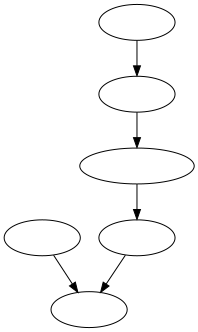

In [13]:
show_dependency_tree(sentences[7])

## 45. 動詞の格パターンの抽出
今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．
* 動詞を含む文節において，最左の動詞の基本形を述語とする
* 述語に係る助詞を格とする
* 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．
```
始める  で
見る    は を
```
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．
* コーパス中で頻出する述語と格パターンの組み合わせ
* 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）

In [14]:
with open("Output/45.txt", mode="w") as f:
    for sentence in sentences:
        for chunk in sentence:
            line = ""

            is_skipped = True
            for morph in chunk.morphs:
                if is_skipped and morph.pos == "動詞":
                    line += morph.base
                    is_skipped = False
            if is_skipped:
                continue

            particles = []
            for src in chunk.srcs:
                for morph in sentence[src].morphs:
                    if morph.pos == "助詞":
                        particles.append(morph.base)
            if len(particles) == 0:
                continue

            line += "\t"
            line += " ".join(particles)
            line += "\n"
            line = line.replace("。", "").replace("、", "")
            f.write(line)

In [15]:
!sort Output/45.txt 2>/dev/null | uniq -c | sort -r -k 1 2>/dev/null

    560 云う	と
    436 する	を
    247 思う	と
    198 ある	が
    185 なる	に
    174 する	に
    172 見る	て
    120 する	と
    119 する	が
     93 見る	を
     90 見える	と
     77 する	て を
     62 する	を に
     58 もつ	を
     57 する	は
     55 云う	を
     55 する	て
     54 する	が を
     53 ある	の
     50 出来る	が
     49 行く	へ
     49 云う	て と
     49 する	から
     46 する	に を
     45 聞く	を
     44 ある	も
     40 なる	が に
     40 する	で を
     40 ある	に
     39 食う	を
     39 する	の
     38 する	と を
     37 思う	か と
     35 至る	に
     34 知る	を
     33 来る	が
     33 する	で
     33 ある	は
     32 する	も
     32 ある	に が
     31 よる	に
     31 やる	を
     30 いう	と
     29 持つ	を
     29 なる	と
     29 する	は を
     29 する	から を
     27 出る	が
     27 出す	を
     26 なる	て に
     25 ある	は が
     24 云う	が と
     24 云う	か と
     24 なる	が
     24 とる	を
     23 読む	を
     23 いる	に
     22 云う	とか
     22 云う	から と
     21 云う	に と
     20 行く	に
     20 向う	に
     20 入る	に
     20 つける	を
     20 する	が に
     19 逢う	に
     19 見る	て て
     19 見る	から
     19 行く	て
     19 云う	は と
     19 する	は に
     18 見る	て を
     17 聞く

      1 限る	で と も
      1 限る	で が と も
      1 限る	て から は か に
      1 限る	て か と は に
      1 限る	が と も
      1 限る	から は か に
      1 降る	は に
      1 降る	に
      1 降る	と に が に
      1 降る	と
      1 降る	て か と から
      1 降る	が
      1 降り込む	が
      1 降りる	は て
      1 降りる	は から て
      1 降りる	どころか へ
      1 降りる	て
      1 降らせる	から を に
      1 降す	に は を へ
      1 附す	を へ に を
      1 附ける	と か で も
      1 阿る	から
      1 関する	て は に
      1 関す	が に
      1 間違える	を と
      1 間違える	まで と を
      1 間違える	かい と
      1 間違う	よ
      1 間違う	は
      1 間違う	と
      1 間違う	て ば
      1 間違う	が
      1 間に合う	で
      1 間に合う	って
      1 間に合う	ちゃ
      1 間に合う	から まで に
      1 開け放つ	を
      1 開ける	を を
      1 開ける	を
      1 開ける	へ を に
      1 開ける	は など で
      1 開ける	なぞ も から
      1 開ける	と
      1 開ける	でも を
      1 開ける	て を
      1 開ける	て も
      1 開ける	て
      1 開ける	だけ が を
      1 開ける	が が
      1 開ける	から を か に
      1 開く	を に
      1 開く	も を
      1 開く	へ の
      1 開く	は を
      1 開く	ので と を へ
      1 開く	に も を
      1 開く	と を とも
      1 開く	で の
      1 開く	で と は を
    

      1 問いかける	は て
      1 問いかける	と は で
      1 問いかける	て と に
      1 問いかける	か ね と は に
      1 唸る	ので て か
      1 唸る	と
      1 唸る	て と に ね と
      1 唸る	て
      1 唸る	ぜ に で で
      1 唱える	と
      1 唱う	を
      1 咽ぶ	て と
      1 咲く	に が
      1 咎める	は が
      1 咎める	か て も
      1 命ずる	も を
      1 命ずる	へ を
      1 命ずる	て に を
      1 命ずる	て て と が に
      1 命ずる	ちゃ は から
      1 命ずる	が を
      1 命じる	を
      1 命じる	に か を
      1 命じる	と
      1 呼ぶ	を って を
      1 呼ぶ	へ へ へ へ から
      1 呼ぶ	へ と から
      1 呼ぶ	へ
      1 呼ぶ	は は て と
      1 呼ぶ	は に を へ
      1 呼ぶ	は が
      1 呼ぶ	は
      1 呼ぶ	に対して は を と
      1 呼ぶ	と は と か て を と
      1 呼ぶ	と で よ と
      1 呼ぶ	と で から を
      1 呼ぶ	と が を
      1 呼ぶ	と
      1 呼ぶ	で を と
      1 呼ぶ	で を
      1 呼ぶ	で と で が を
      1 呼ぶ	て のに は を
      1 呼ぶ	て から に は を
      1 呼ぶ	が を と
      1 呼ぶ	から
      1 呼びつける	を
      1 呼びつける	に
      1 呼びかける	と
      1 呼ばわる	と
      1 味わう	が を
      1 周章てる	は
      1 呑む	を
      1 呑む	ば
      1 呑む	て
      1 呑む	が を
      1 呑む	が に
      1 呑む	から
      1 呑み込む	ね と を まで
      1 呑み込

      1 あける	を と
      1 あける	へ を
      1 あける	は
      1 あける	ので て へ
      1 あける	に を
      1 あける	と
      1 あける	て を
      1 あける	て か と ばかり に を
      1 あける	が を で に
      1 あく	も
      1 あく	は の が
      1 あく	に が
      1 あく	と の が
      1 あく	と に て を
      1 あく	と が
      1 あく	と
      1 あく	が
      1 あく	から が と
      1 あきれ返る	も
      1 あきる	が を
      1 あきる	か
      1 あきらめる	は と
      1 あきらめる	て と
      1 あきらめる	じゃ
      1 あきらめる	くらい
      1 あきらめる	が て から と
      1 あがる	は
      1 あがる	と に
      1 あがる	て
      1 あがる	が に
      1 あがる	が と共に
      1 あがる	から を
      1 あがる	から へ
      1 あう	が に


In [16]:
!grep -E "^する" Output/45.txt | cut -f 2 | sort | uniq -c | sort -r -k 1

    436 を
    174 に
    120 と
    119 が
     77 て を
     62 を に
     57 は
     55 て
     54 が を
     49 から
     46 に を
     40 で を
     39 の
     38 と を
     33 で
     32 も
     29 は を
     29 から を
     20 が に
     19 は に
     16 と が
     16 て に
     15 は と
     15 て と
     14 と は
     12 ば
     11 と は を
     11 か
     10 に は
     10 と が を
      9 に が
      9 て も
      9 から に
      8 まで
      8 は て
      8 でも
      8 で も
      8 で が
      8 て は
      8 て て
      7 を と
      7 へ
      7 は て を
      7 で に
      7 さえ
      7 くらい に
      7 が と
      6 を が
      6 も に
      6 まで を
      6 は が
      6 に に
      6 と も
      6 で に を
      6 で が を
      6 て て を
      6 くらい
      6 が に を
      5 をもって
      5 は も
      5 に は を
      5 なんか
      5 など と
      5 と に
      5 て を に
      5 て が
      5 が を に
      5 が で を
      5 か と
      4 よ と
      4 も を
      4 も が
      4 まで に
      4 へ を
      4 ば を
      4 は に を
      4 は て に
      4 に を に
      4 に も
      4 でも を
      4 て の
      4 て に を
     

In [17]:
!grep -E "^見る" Output/45.txt | cut -f 2 | sort | uniq -c | sort -r -k 1

    172 て
     93 を
     19 て て
     19 から
     18 て を
     14 と
     12 で
     11 は て
     10 から て
      8 に
      8 が を
      7 が
      6 は て を
      4 を に
      4 は て て
      4 に を
      4 で を
      4 が て
      3 も
      3 ので て
      3 と を
      3 と て
      3 から を
      3 か て
      2 も て
      2 ば て て
      2 ば て
      2 は を
      2 は で を
      2 は
      2 の
      2 と は て
      2 で が
      2 て て て
      2 たり て
      2 から て て
      2 か
      1 を で
      1 を て て
      1 を て
      1 を から
      1 より も
      1 より で を
      1 より
      1 も によって
      1 も と て
      1 も で ばかり
      1 も だけ
      1 まで を
      1 まで て
      1 へ も て
      1 へ な と
      1 ばかり に て が ね と を に
      1 ば と て
      1 ば が と て
      1 ば が て
      1 は は
      1 は の を
      1 は に
      1 は と
      1 は で も
      1 は で で
      1 は で て
      1 は て と に を が
      1 は て で を
      1 は が て
      1 は から て
      1 は か ね ば ばかり て
      1 は か て
      1 のに と で
      1 ので と ながら
      1 ので て て
      1 ので が
      1 の を
      1 の に は て
     

In [18]:
!grep -E "^与える" Output/45.txt | cut -f 2 | sort | uniq -c | sort -r -k 1

      3 に を
      1 ば を
      1 は て に を に
      1 は て に を
      1 に は に対して のみ は も
      1 に け を
      1 として を か
      1 と は て を
      1 で だけ に を
      1 て も を
      1 て は に を
      1 て に を
      1 て が は は と て に を
      1 たり て に を
      1 けれども に は を
      1 が を


## 46. 動詞の格フレーム情報の抽出
45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．
* 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
* 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．
```
始める  で      ここで
見る    は を   吾輩は ものを
```

In [19]:
with open("Output/46.txt", mode="w") as f:
    for sentence in sentences:
        for chunk in sentence:
            line = ""

            is_skipped = True
            for morph in chunk.morphs:
                if is_skipped and morph.pos == "動詞":
                    line += morph.base
                    is_skipped = False
            if is_skipped:
                continue

            particles, arguments = [], []
            for src in chunk.srcs:
                particle, argument = None, ""
                for morph in sentence[src].morphs:
                    argument += morph.surface
                    if morph.pos == "助詞":
                        particle = morph.base
                if particle is not None:
                    particles.append(particle)
                    arguments.append(argument)
            if len(particles) == 0:
                continue

            line += "\t"
            line += " ".join(particles)
            line += "\t"
            line += " ".join(arguments)
            line += "\n"
            line = line.replace("。", "").replace("、", "")
            f.write(line)

In [20]:
!cat Output/46.txt

生れる	で	どこで
つく	と が	かとんと 見当が
泣く	で	した所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て
思う	から	なかったから
載せる	に	掌に
持ち上げる	て と	載せられて スーと
ある	が	感じが
落ちつく	で	上で
見る	て を	落ちついて 顔を
見る	の	ものの
思う	と	ものだと
残る	が でも	感じが 今でも
する	をもって	第一毛をもって
する	が	顔が
逢う	も	猫にも
出会う	も	一度も
する	が	真中が
吹く	から と を	中から ぷうぷうと 煙を
弱る	て	咽せぽくて
飲む	の	人間の
知る	は	事は
坐る	で に	裏で 心持に
おる	て	坐って
する	が と で	おったが すると 速力で
動く	が	書生が
動く	か が	動くのか 自分だけが
分る	か	動くのか
廻る	が が	分らないが 眼が
なる	が	胸が
思う	と	助からないと
する	と が	どさりと 音が
出る	と て から が	思っていると して 眼から 火が
する	は	それまでは
分る	が は やら も	記憶しているが あとは 事やら 考え出そうとしても
付く	が	気が
見る	て	付いて
いる	と は	見ると 書生は
見える	が も	兄弟が 一疋も
隠す	さえ を	母親さえ 姿を
違う	は	所とは
明く	を	眼を
見る	て	這い出して
棄てる	は から に へ	吾輩は 上から 急に 中へ
這い出す	で を	思いで 笹原を
ある	と に が	這い出すと 向うに 池が
坐る	に	前に
する	て	坐って
考える	と	よかろうと
見る	は て	吾輩は 考えて
出る	も	分別も
泣く	て	して
来る	が に	書生がまた 迎に
考え付く	と	来てくれるかと
やる	と	ニャーと
見る	て	やって
来る	が も	見たが 誰も
渡る	を と が	池の上を さらさらと 風が
かかる	て が	渡って 日が
減る	が に	腹が 非常に
ある	の	食物の
ある	まで	所まで
する	と を	こうと 決心を
廻る	て と を に	して そろりそろりと 池を 左りに
する	を	そこを
這う	て に	我慢して 無理やりに
出る	と で へ	這って行くと 事で 所へ
這入る	へ	ここへ
思う

申す	ば から	申しますれば 美的価値から
存じる	と	適当かと
笑う	は と	主人は 「フフフフ」と
笑う	も に	迷亭自身も 愉快そうに
弁じる	まで	ただ今まで
よす	から	下品ですから
やる	と は を	よしていただきましょう」と 寒月君は 復讐を
洗う	から を	「さようしから ば顔を
出直す	て	洗って
する	に	権衡に
思う	と	一言論及したいと
やる	に を	単独に 鼻論を
ある	へ で が	どこへ 鼻——鞍馬山で 展覧会が
思う	と	一等賞だろうと
する	を	鼻を
いらせられる	て	所有して
切る	を で	鼻を 鋏で
する	て へ	ちょん切って 顔へ
云う	と	猫の額と
聳える	も へ が として	喩えにも 地面へ 鼻柱が 突兀として
据え付ける	へ を	上へ 奈良の大仏を
失する	を	比例を
落す	を	美的価値を
思う	と	事だろうと
する	を	周囲を
刻む	に を	根に 八字を
釣る	で を	刻んで 眼を
する	に	顔に
あり	て	して
嘆ずる	と	ありと
得る	を	嘆ぜざるを
途切れる	が	言葉が
話す	の	鼻の
する	で を	方で 話しを
云う	と	張だろう」と
聞える	が	声が
教える	と が に	神さんだ」と 主人が 迷亭に
やる	は	迷亭は
ある	に の	新たに 傍聴者の
する	にあたって を	裏手にあたって 事を
思う	と	名誉と
もつ	を	嬌音を
なる	て	もって
添える	に を	講筵に 艶味を
引く	に	通俗的に
背く	て に	引き直して 眷顧に
期する	を	事を
立ち入る	は に	これからは 問題に
知れる	は かも	勢御婦人方には にくいかも
願う	が ので を	訳でありますが 立ち入りますので 御辛防を
云う	と	力学と
聞く	を	語を
する	は て	寒月君は 聞いてまた
証拠立てる	の	「私の
する	は と は	証拠立てようとするのは 鼻と 顔は
失す	を	黄金律を
云う	と	失していると
する	を に から	それを 厳格に 公式から
入れる	んで て に	云う事なんで 演繹して 御覧に
云う	と	入れようと
する	を と	Ｈを 高さと
生ずる	より	交叉より
下さる	は と	Ｗは 重量と
なる	に	お分りに
云う	と が	ものか」と 主人が
分る	に と	「私に もちと
困る	な	分りかねますな」
分る	は から	沙弥

��る	を に	ボールを 邸内に
映ずる	に	眼に
慣れる	は に	空間は 排列に
分る	ば	見れば
かく	を	それを
挑む	に に を	ずるに 主人に 戦争を
する	は ども	こうなっては 主人といえども
きく	から を	うちから 講義を
する	て	きいて
立ち上がる	は として	主人は 奮然として
出す	として	猛然として
捕る	として を	驀然として 一人を
する	に	主人に
生える	の	髯の
思う	と	沢山だと
引っ張る	を に	詫び入るのを 無理に
連れる	て まで	引っ張って 前まで
する	に について	ここに 策略について
ある	が	必要が
見る	が を	主人が 権幕を
する	で	自身で
察す	は て は と	敵は 見て 様子では 相違ないと
まつ	て	損じて
なる	は	まっては
拾う	を	小供を
やる	に	玉拾いに
避ける	を	危険を
越す	て に	やって 避けるに
つる	が を	主人が 小供を
捏ねる	て を	つらまえて 理窟を
する	は	名誉には
する	を に	ものを 相手に
なる	って に	捏ね廻したって 恥辱に
云う	が と	相手が 人間でないと
入れる	を に	事を うちに
忘れる	は を	敵は 入れるのを
ある	に が	主人に 常識が
飛び出す	ば だって	あれば 昨日だって
釣る	を に	人間を 程度以上に
上げる	し	釣るし
ある	の	常識の
与える	は て に を	逆上は 上げて ものに 非常識を
ある	の	見境いの
誇る	を以て に	逆上を以て 人に
足る	は に	うちは 誇るに
なる	に	相手に
する	を って と	中学一年生を 生捕って 人質と
出来る	の は は	主人のごとく 了見でなくては 仲間入りは
勤める	によって を	命令によって 役を
追い詰める	に	天才に
ある	て も	追い詰められて 越える間も
引く	こそ に	あらばこそ 庭前に
見る	を	恥辱を
行く	と は に	なると 敵軍は 訳に
乗る	を	我もと四つ目垣を
乱れる	も て から に	我も 乗りこして 木戸口から 庭中に
並ぶ	は ばかり に	数は 約一ダースばかり 前に
つける	は も	大抵は 着も
まくる	を	腕を
する	て を	まくって 腕組を
ある	が	したのが
乗せる	を に へ	洗いざらしを 申し訳に 背中だけへ
ある	が	乗せているのが
思

## 47. 機能動詞構文のマイニング
動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．
* 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
* 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
* 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
* 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．
```
返事をする      と に は        及ばんさと 手紙に 主人は
```
このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．
* コーパス中で頻出する述語（サ変接続名詞+を+動詞）
* コーパス中で頻出する述語と助詞パターン

In [21]:
with open("Output/47.txt", mode="w") as f:
    for sentence in sentences:
        sahen_idx, sahen_noun, wo = None, "", ""
        for idx, chunk in enumerate(sentence):
            line = ""

            for morph in chunk.morphs:
                if morph.pos1 == "サ変接続":
                    sahen_idx, sahen_noun, wo = idx, morph.base, ""
                elif sahen_noun != "" and morph.base == "を":
                    wo = morph.base
                elif sahen_noun != "" and wo != "" and morph.pos == "動詞":
                    line = morph.base
                    break
                else:
                    sahen_noun, wo = "", ""
            if sahen_noun != "" and wo != "" and line != "":
                line = sahen_noun + wo + line
            else:
                continue

            particles, arguments = [], []
            for src in chunk.srcs:
                if src >= sahen_idx:
                    continue
                particle, argument = None, ""
                for morph in sentence[src].morphs:
                    argument += morph.surface
                    if morph.pos == "助詞":
                        particle = morph.base
                if particle is not None:
                    particles.append(particle)
                    arguments.append(argument)
            if len(particles) == 0:
                continue

            line += "\t"
            line += " ".join(particles)
            line += "\t"
            line += " ".join(arguments)
            line += "\n"
            line = line.replace("。", "").replace("、", "")
            f.write(line)

In [22]:
!cut -f 1 Output/47.txt | sort | uniq -c | sort -r -k 1

     27 返事をする
     19 挨拶をする
     10 話をする
      7 喧嘩をする
      6 真似をする
      5 質問をする
      5 質問をかける
      5 相談をする
      5 昼寝をする
      4 降参をする
      4 辞儀をする
      4 演説をする
      4 注意をする
      4 欠伸をする
      4 休養を要する
      3 講釈をする
      3 落着を告げる
      3 病気をする
      3 活躍を試みる
      3 決心をする
      3 批評を願う
      3 安心を得る
      3 同情を表する
      2 迫害を加える
      2 議論をする
      2 講義をする
      2 談話を聞く
      2 話を聞く
      2 話をつづける
      2 観察を怠る
      2 覚悟をする
      2 行水を使う
      2 著述をする
      2 苦心をする
      2 自炊をする
      2 結婚を申し込む
      2 散歩をする
      2 放蕩をする
      2 掃除をする
      2 抗議を申し込む
      2 思案を定める
      2 往来をあるく
      2 座禅をする
      2 宙返りをする
      2 噂をする
      2 問答をする
      2 同情を表す
      2 化粧をする
      2 刺激を与える
      2 修行をする
      2 一段落を告げる
      2 いたずらをする
      1 鞭撻を加える
      1 震動をはじめる
      1 電話を切る
      1 雑談をする
      1 随行を命ずる
      1 降参を申し込む
      1 関係をつける
      1 間食をする
      1 鑑定をつける
      1 酷評を加える
      1 邪魔を致す
      1 邪魔をする
      1 遠慮をする
      1 遠征をする
      1 道楽をする
      1 道楽をすすめる
      1 運動を始める
      

In [23]:
!grep -E "^返事をする" Output/47.txt | cut -f 2 | sort | uniq -c | sort -r -k 1

      7 と
      3 は と
      1 も
      1 へ
      1 は
      1 と は に
      1 と は と
      1 と は で
      1 と は
      1 と に
      1 と と は に
      1 と が から に
      1 と が
      1 と から
      1 て と
      1 て
      1 から と
      1 から て で
      1 から て


In [24]:
!grep -E "^挨拶をする" Output/47.txt | cut -f 2 | sort | uniq -c | sort -r -k 1

      4 と
      4 から
      2 と も
      1 は て と
      1 ので て
      1 と は によって の
      1 と は で
      1 と は
      1 で に
      1 で
      1 て
      1 が て と


## 48. 名詞から根へのパスの抽出
文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．
* 各文節は（表層形の）形態素列で表現する
* パスの開始文節から終了文節に至るまで，各文節の表現を"`->`"で連結する

「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．
```
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
```

In [32]:
with open("Output/48.txt", mode="w") as f:
    for sentence in sentences:
        for chunk in sentence:
            root, is_skipped = "", True
            for morph in chunk.morphs:
                root += morph.surface
                if morph.pos == "名詞":
                    is_skipped = False
            if is_skipped:
                continue

            def _stretch_line(dst: int):
                if dst == -1:
                    return ""
                else:
                    chunk_dst, node = sentence[dst], ""
                    for morph in chunk_dst.morphs:
                        node += morph.surface
                    return " -> " + node + _stretch_line(chunk_dst.dst)

            line = root
            line += _stretch_line(chunk.dst)
            line += "\n"
            line = line.replace("。", "").replace("、", "")
            f.write(line)

In [33]:
!head -20 Output/48.txt

一
吾輩は猫である
名前は -> 無い
どこで -> 生れた -> かとんと -> つかぬ
かとんと -> つかぬ
見当が -> つかぬ
何でも -> 薄暗い -> 泣いて -> 記憶している
した所で -> 泣いて -> 記憶している
いた事だけは -> 記憶している
記憶している
吾輩は -> 見た
ここで -> 始めて -> 人間という -> ものを -> 見た
人間という -> ものを -> 見た
ものを -> 見た
あとで -> 聞くと -> そうだ
それは -> そうだ
書生という -> 人間中で -> 種族であった -> そうだ
人間中で -> 種族であった -> そうだ
一番 -> 獰悪な -> 種族であった -> そうだ
獰悪な -> 種族であった -> そうだ


## 49. 名詞間の係り受けパスの抽出
文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号が$i$と$j$（$i<j$）のとき，係り受けパスは以下の仕様を満たすものとする．
* 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を"`->`"で連結して表現する
* 文節$i$と$j$に含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．
* 文節$i$から構文木の根に至る経路上に文節$j$が存在する場合: 文節$i$から文節$j$のパスを表示
* 上記以外で，文節$i$と文節$j$から構文木の根に至る経路上で共通の文節$k$で交わる場合: 文節$i$から文節$k$に至る直前のパスと文節$j$から文節$k$に至る直前までのパス，文節kの内容を"`|`"で連結して表示

例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．
```
Xは | Yで -> 始めて -> 人間という -> ものを | 見た
Xは | Yという -> ものを | 見た
Xは | Yを | 見た
Xで -> 始めて -> Y
Xで -> 始めて -> 人間という -> Y
Xという -> Y
```

In [37]:
with open("Output/49.txt", mode="w") as f:
    for sentence in sentences:
        for i in range(len(sentence)-1):
            chunk_i = sentence[i]
            node_i, is_skipped = "", True
            for morph in chunk_i.morphs:
                if morph.pos == "名詞":
                    node_i += "X"
                    is_skipped = False
                else:
                    node_i += morph.surface
            if is_skipped:
                continue

            path_i = {i: node_i}
            def _stretch_path(path: dict, dst: int):
                if dst != -1:
                    chunk_dst, node = sentence[dst], ""
                    for morph in chunk_dst.morphs:
                        node += morph.surface
                    path[dst] = node
                    _stretch_path(path, sentence[dst].dst)
            _stretch_path(path_i, chunk_i.dst)

            for j in range(i+1, len(sentence)):
                chunk_j = sentence[j]
                node_j, is_skipped = "", True
                for morph in chunk_j.morphs:
                    if morph.pos == "名詞":
                        node_j += "Y"
                        is_skipped = False
                    else:
                        node_j += morph.surface
                if is_skipped:
                    continue

                path_j = {j: node_j}
                _stretch_path(path_j, chunk_j.dst)

                line = node_i
                for k, node_k in path_i.items():
                    if k == i:
                        continue
                    if j in path_i.keys() and k == j:
                        line += " -> " + node_j
                        break
                    elif j not in path_i.keys() and k in path_j.keys():
                        line += " | " + node_j
                        for l, node_l in path_j.items():
                            if l != j and l != k:
                                line += " -> " + node_l
                        line += " | " + node_k
                    else:
                        line += " -> " + node_k

                line += "\n"
                line = line.replace("。", "").replace("、", "")
                f.write(line)